Single Layer Nueral Network With Slow Learning Rates

In [1]:
import torch    # Base torch library
import torch.nn as nn   # Nueral network modules 
import torch.optim as optim    # Optimization algorithms
import torch.nn.functional as F    # Acitvation functions
from torch.utils.data import DataLoader    # Minibathces
import torchvision
import torchvision.datasets as datasets     # MNIST dataset 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

ModuleNotFoundError: No module named 'torch'

Network Class

In [2]:
class NN(nn.Module):

    def __init__(self, input_size, middle_width, num_classes):


        super(NN, self).__init__()
        self.features = nn.Sequential(OrderedDict([
            ('hidden_layer', nn.Linear(input_size, middle_width)),
            ('hidden_activation', nn.ReLU()),
            ('readout', nn.Linear(middle_width, num_classes))
        ]))

    def forward(self, x):
        x = self.features(x)

        return x

Checking for GPU.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Hyper Parameters

In [4]:
hp = {
    "Input Size": 784,
    "Middle Layer Width": 2000,
    "Num Classes": 10,
    "Regular Learning Rate": 0.1,
    "Slow Learning Rate": 1e-4,
    "Batch Size": 200,
    "Epochs": 1250
}

Initializing two models, one with the slowed learning rates and another "regular" model

In [5]:
slow_model = NN(input_size=hp["Input Size"],
                middle_width=hp["Middle Layer Width"],
                num_classes=hp["Num Classes"]).to(device=device)

reg_model = NN(input_size=hp["Input Size"],
               middle_width=hp["Middle Layer Width"],
               num_classes=hp["Num Classes"]).to(device=device)

Loading MNIST dataset

In [6]:
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=hp['Batch Size'], shuffle=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=hp['Batch Size'], shuffle=True)

Optimizers

In [7]:
loss_function = nn.CrossEntropyLoss()
slow_optimizer = optim.SGD([{'params': slow_model.features.hidden_layer.parameters()},
                          {'params': slow_model.features.readout.parameters(),
                           'lr': hp["Regular Learning Rate"]}],
                           lr=hp["Slow Learning Rate"])
reg_optimizer = optim.SGD(reg_model.parameters(), lr=hp["Regular Learning Rate"])

Setting things up for graphing later on...

In [8]:
import pandas as pd
import seaborn as sns
df1 = pd.DataFrame()
current = 1

In [9]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y =y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            # 64images x 10, 
            
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return 100 - float(num_correct)/float(num_samples)*100

Training model

In [10]:
for epoch in range(hp['Epochs']):
    for batch_idx, (data, targets) in enumerate(train_loader):

        """
        print(data.shape)

        # the output should look something like 784 iterations of "torch.Size([64, 1, 28, 28])
        # where, 64 represents the number of images (i.e. the batchsize)
        # 1 represents the number of channels, since MNIST is black and white it only has one (rgb would be 3)
        # 28, 28 represents th height and width of each image
        """
        # Get to correct shape
        data = data.reshape(data.shape[0], -1).to(device=device)
        targets = targets.to(device=device)
        # forward 
        sl_scores = slow_model(data)
        sl_loss = loss_function(sl_scores, targets)

        r_scores = reg_model(data)
        r_loss = loss_function(r_scores, targets)
        # backward
        slow_optimizer.zero_grad()
        sl_loss.backward()
        
        reg_optimizer.zero_grad()
        r_loss.backward()

        # gradient descent or adam step
        slow_optimizer.step()
        reg_optimizer.step()
        
    
    d = {'epoch': [current], 'Slow w/ Train': [check_accuracy(train_loader, slow_model)], 'Slow w/ Test': [check_accuracy(test_loader, slow_model)], 'Reg. w/ Train': [check_accuracy(train_loader, reg_model)], 'Reg. w/ Test': [check_accuracy(test_loader, reg_model)]} 
    df2 = pd.DataFrame.from_dict(d)
    df1 = df1.append(df2)
    current += 1

KeyboardInterrupt: 

Displaying results

In [11]:
df1 = df1.reset_index().drop(columns=['index'], axis=1)
df2 = df1.melt('epoch', var_name = 'cols', value_name= 'vals')

In [12]:
# Saving the data to a csv.
df2.to_csv("error_rate.csv")

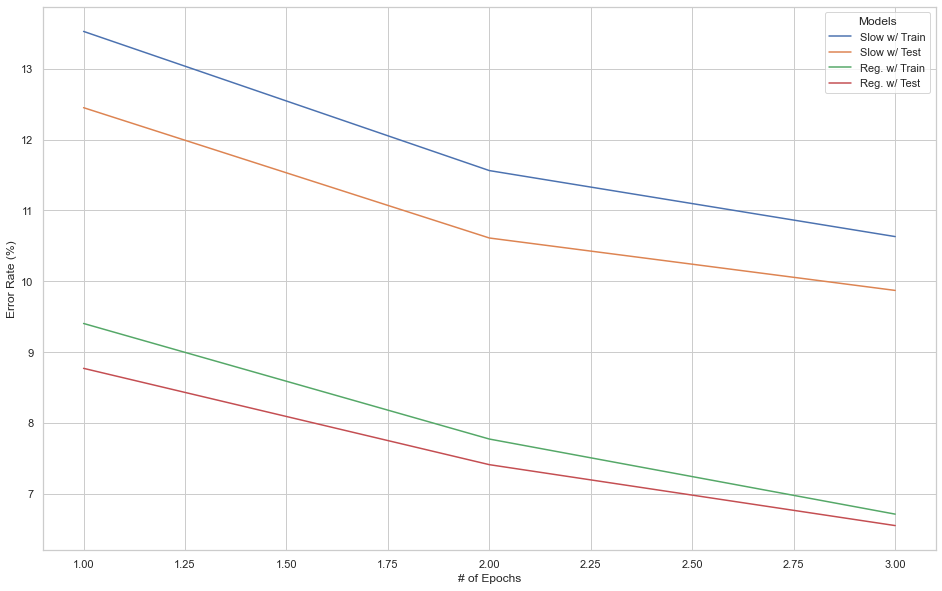

In [13]:
sns.set(rc = {'figure.figsize':(16,10)}) # setting figure size
sns.set_style('whitegrid') # setting seaborn theme 
sns.lineplot(x="epoch", y="vals", hue='cols', data=df2)

plt.legend(title = 'Models', 
           loc = 'best', labels = ['Slow w/ Train', 'Slow w/ Test', 'Reg. w/ Train', 'Reg. w/ Test']); # legened title and placement 

# labeling x-axis
plt.xlabel("# of Epochs");
plt.ylabel("Error Rate (%)");